<a href="https://colab.research.google.com/github/vaishnavipatil29/NN_DL_Lab/blob/main/Lab6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 6 : Recurrent Neural Networks

Name : Vaishnavi, Joshitha

Roll Number : 180020039, 180020008

Referrence Material : 

1. https://github.com/pangolulu/rnn-from-scratch
2. https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/


#**Problem 1** : Next Token Prediction in a Sequence

Observation to be demonstrated:

1. Generate the data required
2. Represent tokens as indices using dictionaries
3. Convert the tokens into vectors using One hot encoding
4. Implement Recurrent Neural Network to solve the Next token prediction problem

##Write down the Objectives, Hypothesis and Experimental description for the above problem



Objectives : Implement RNN, and make it predict the next letter in the sequence. 

Hypothesis : The RNN should redict the next sequence. 

Experimental description : 1. Create the aprropiate dataset. 

2. Implement RNN

3. See the predictions.


## Programming : 


1. **Representing tokens or text**

In previous labs we mainly considered data $x \in \mathrm{R}^d$, where $d$ is the feature space dimension.
With time sequences our data can be represented as $x \in \mathrm{R}^{t \, \times \, d}$, where $t$ is the sequence length. 
This emphasises sequence dependence and that the samples along the sequence are not independent and identically distributed (i.i.d.).
We will model functions as $\mathrm{R}^{t \, \times \, d} \rightarrow \mathrm{R}^c$, where $c$ is the amount of classes in the output.

There are several ways to represent sequences. With text, the challenge is how to represent a word as a feature vector in $d$ dimensions, as we are required to represent text with decimal numbers in order to apply neural networks to it.

In this exercise we will use a simple one-hot encoding but for categorical variables that can take on many values (e.g. words in the English language) this may be infeasible. For such scenarios, you can project the encodings into a smaller space by use of embeddings.

2. **One-hot encoding over vocabulary**

One way to represent a fixed amount of words is by making a one-hot encoded vector, which consists of 0s in all cells with the exception of a single 1 in a cell used uniquely to identify each word.

| vocabulary    | one-hot encoded vector   |
| ------------- |--------------------------|
| Paris         | $= [1, 0, 0, \ldots, 0]$ |
| Rome          | $= [0, 1, 0, \ldots, 0]$ |
| Copenhagen    | $= [0, 0, 1, \ldots, 0]$ |

Representing a large vocabulary with one-hot encodings often becomes inefficient because of the size of each sparse vector.
To overcome this challenge it is common practice to truncate the vocabulary to contain the $k$ most used words and represent the rest with a special symbol, $\mathtt{UNK}$, to define unknown/unimportant words.
This often causes entities such as names to be represented with $\mathtt{UNK}$ because they are rare.

Consider the following text
> I love the corny jokes in Spielberg's new movie.

where an example result would be similar to
> I love the corny jokes in $\mathtt{UNK}$'s new movie.

## Generating a dataset

For this exercise we will create a simple dataset that we can learn from. We generate sequences of the form:

`a a a a b b b b EOS`, `a a b b EOS`, `a a a a a b b b b b EOS`

where `EOS` is a special character denoting the end of a sequence. The task is to predict the next token $t_n$, i.e. `a`, `b`, `EOS` or the unknown token `UNK` given the sequence of tokens $\{ t_{1}, t_{2}, \dots , t_{n-1}\}$ and we are to process sequences in a sequential manner. As such, the network will need to learn that e.g. 5 `b`s and an `EOS` token will occur following 5 `a`s.

In [ ]:
import numpy as np
import sys

def generate_dataset(num_sequences=500):
    """
    Generates a number of sequences as our dataset.
    
    Input :
     `num_sequences`: the number of sequences to be generated.
     
    Returns a list of sequences.
    """
    samples = []
    
    ## Write your code here
    
    for i in range(num_sequences): 
        num_tokens = np.random.randint(5, 8)
        sample = ['a'] * num_tokens + ['b'] * num_tokens + ['EOS']
        samples.append(sample)

    return samples


sequences = generate_dataset()

print('A single sample from the generated dataset:')
print(sequences[0])

A single sample from the generated dataset:
['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']


## Representing tokens as indices

To build a one-hot encoding, we need to assign each possible word in our vocabulary an index. We do that by creating two dictionaries: one that allows us to go from a given word to its corresponding index in our vocabulary, and one for the reverse direction. Let's call them `word_to_idx` and `idx_to_word`. The keyword `num_words` specifies the maximum size of our vocabulary. If we try to access a word that does not exist in our vocabulary, it is automatically replaced by the `UNK` token or its corresponding index.

In [ ]:
# from collections import defaultdict

def sequences_to_dicts(sequences):
    """
    Create word_to_idx and idx_to_word dictionaries for a list of sequences.
    """

    ## Write your code here
    num_sequences = len(sequences)
   # words= ['a','b', 'EOS', 'UNK']
    x = np.array(sequences[0])
    words = list(np.unique(x))
    words.append('UNK') 
    word_to_idx = {k:v for v,k in enumerate(words)}
    idx_to_word = {v:k for v,k in enumerate(words)}
    vocab_size = len(words)
    return word_to_idx, idx_to_word, num_sequences, vocab_size


word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

print("Word to Index Dictionary : ",dict(word_to_idx))
print("Index to Word Dictionary : ",dict(idx_to_word))
print("Number of Sequences : ",num_sequences)
print("Vocab Size : ",vocab_size)


Word to Index Dictionary :  {'EOS': 0, 'a': 1, 'b': 2, 'UNK': 3}
Index to Word Dictionary :  {0: 'EOS', 1: 'a', 2: 'b', 3: 'UNK'}
Number of Sequences :  500
Vocab Size :  4


## Creating Dataset 

To build our dataset, we need to create inputs and targets for each sequences and partition sentences it into training and test sets. 80% and 20% is a common distribution, but mind you that this largely depends on the size of the dataset. **Since we are doing next-word predictions, our target sequence is simply the input sequence shifted by one word.**

In [ ]:
    
def create_datasets(sequences, p_train=0.8, p_test=0.2):
    # Define partition sizes
      num_train = int(len(sequences)*p_train)
      num_test = int(len(sequences)*p_test)

      # Split sequences into partitions
      sequences_train = sequences[:num_train]
      sequences_test = sequences[-num_test:]

      def get_inputs_targets_from_sequences(sequences):
          # Define empty lists
          inputs, targets = [], []
          
          # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
          # but targets are shifted right by one so that we can predict the next word

          ## Write your code here
                  # Define empty lists
          inputs, targets = [], []
          
          # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
          # but targets are shifted right by one so that we can predict the next word
          for sequence in sequences:
              inputs.append(sequence[:-1])
              targets.append(sequence[1:])


              
          return inputs, targets

      # Get inputs and targets for each partition
      inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
      inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)
      

      return inputs_train,targets_train,inputs_test,targets_test
    

x_train,y_train,x_test,y_test = create_datasets(sequences)

print("Input for the first training sample : ",x_train[0])
print("Target output for the first training sample : ",y_train[0])


Input for the first training sample :  ['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b']
Target output for the first training sample :  ['a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']


In [ ]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

    
def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]

    def get_inputs_targets_from_sequences(sequences):
        # Define empty lists
        inputs, targets = [], []
        
        # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
        # but targets are shifted right by one so that we can predict the next word
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
            
        return inputs, targets

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set
    

training_set, validation_set, test_set = create_datasets(sequences, Dataset)

print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(validation_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')

We have 400 samples in the training set.
We have 50 samples in the validation set.
We have 50 samples in the test set.


## One-hot encodings

We now create a simple function that returns the one-hot encoded representation of a given index of a word in our vocabulary. Notice that the shape of the one-hot encoding is equal to the vocabulary (which can be huge!). Additionally, we define a function to automatically one-hot encode a sentence.

In [ ]:
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Input :
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    one_hot = np.zeros(vocab_size)
    
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Input :
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """
    # Encode each word in the sentence
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding


test_word = one_hot_encode(word_to_idx['a'], vocab_size)
print(f'Our one-hot encoding of \'a\' is {test_word}.')
print(f'Our one-hot encoding of \'a\' has shape {test_word.shape}.')

test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
print(f'Our one-hot encoding of \'a b\' is {test_sentence}.')
print(f'Our one-hot encoding of \'a b\' has shape {test_sentence.shape}.')

Our one-hot encoding of 'a' is [0. 1. 0. 0.].
Our one-hot encoding of 'a' has shape (4,).
Our one-hot encoding of 'a b' is [[[0.]
  [1.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [0.]]].
Our one-hot encoding of 'a b' has shape (2, 4, 1).



## Implementation of RNN : 

A recurrent neural network (RNN) is a type of neural network that has been succesful in modelling sequential data, e.g. language, speech, protein sequences, etc.

A RNN performs its computations in a cyclic manner, where the same computation is applied to every sample of a given sequence.
The idea is that the network should be able to use the previous computations as some form of memory and apply this to future computations.
An image may best explain how this is to be understood,

![rnn-unroll image](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/rnn-unfold.png?raw=1)


where it the network contains the following elements:

- $x$ is the input sequence of samples, 
- $U$ is a weight matrix applied to the given input sample,
- $V$ is a weight matrix used for the recurrent computation in order to pass memory along the sequence,
- $W$ is a weight matrix used to compute the output of the every timestep (given that every timestep requires an output),
- $h$ is the hidden state (the network's memory) for a given time step, and
- $o$ is the resulting output.

When the network is unrolled as shown, it is easier to refer to a timestep, $t$.
We have the following computations through the network:

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ usually is an activation function, e.g. $\mathrm{tanh}$.
- $o_t = \mathrm{softmax}(W\,{h_t})$


**Steps :** 

  1. Implement Forward Pass, Backward Pass and Optimisation
  2. Write the training loop
  3. Take care of the exploding gradient problem by clipping the gradients 

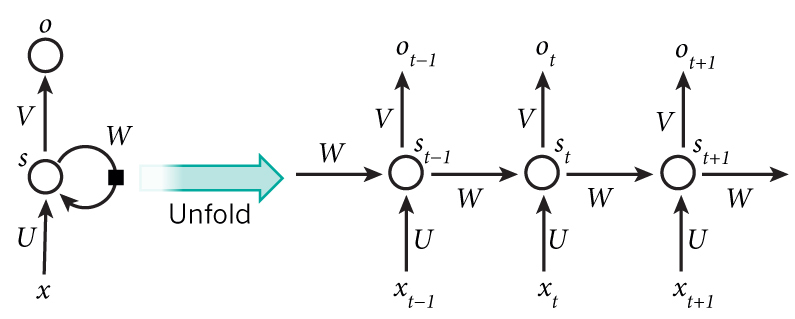

Parameters (W, U, V) are shared in different time steps. And the output in each time step can be softmax. So we used cross entropy loss as an error function

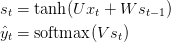

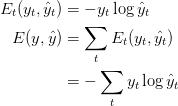

y_t is the correct word at time step t, and y^_t is our prediction. 

In [ ]:
class MultiplyGate:
    def forward(self,W, x):
        return np.dot(W, x)
    def backward(self, W, x, dz):
        dW = np.asarray(np.dot(np.transpose(np.asmatrix(dz)), np.asmatrix(x)))
        dx = np.dot(np.transpose(W), dz)
        return dW, dx

class AddGate:
    def forward(self, x1, x2):
        return x1 + x2
    def backward(self, x1, x2, dz):
        dx1 = dz * np.ones_like(x1)
        dx2 = dz * np.ones_like(x2)
        return dx1, dx2

In [ ]:
class Sigmoid:
    def forward(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    def backward(self, x, top_diff):
        output = self.forward(x)
        return (1.0 - output) * output * top_diff

class Tanh:
    def forward(self, x):
        return np.tanh(x)
    def backward(self, x, top_diff):
        output = self.forward(x)
        return (1.0 - np.square(output)) * top_diff

In [ ]:
mulGate = MultiplyGate()
addGate = AddGate()
activation = Tanh()

class RNNLayer:
    def forward(self, x, prev_s, U, W, V):
        self.mulu = mulGate.forward(U, x)
        self.mulw = mulGate.forward(W, prev_s)
        self.add = addGate.forward(self.mulw, self.mulu)
        self.s = activation.forward(self.add)
        self.mulv = mulGate.forward(V, self.s)
        
    def backward(self, x, prev_s, U, W, V, diff_s, dmulv):
        self.forward(x, prev_s, U, W, V)
        dV, dsv = mulGate.backward(V, self.s, dmulv)
        ds = dsv + diff_s
        dadd = activation.backward(self.add, ds)
        dmulw, dmulu = addGate.backward(self.mulw, self.mulu, dadd)
        dW, dprev_s = mulGate.backward(W, prev_s, dmulw)
        dU, dx = mulGate.backward(U, x, dmulu)
        return (dprev_s, dU, dW, dV)


In [ ]:
class Softmax:
    def predict(self, x):
        exp_scores = np.exp(x)
        return exp_scores / np.sum(exp_scores)
    def loss(self, x, y):
        probs = self.predict(x)
        y = np.argmax(one_hot_encode(word_to_idx[y], vocab_size))
        return -np.log(probs[y])
    def diff(self, x, y):
        probs = self.predict(x)
        y = np.argmax(one_hot_encode(word_to_idx[y], vocab_size))
        probs[y] -= 1.0
        return probs

Initializing the parameters U, V and W is a bit tricky. We can’t just initialize them to 0’s because that would result in symmetric calculations in all our layers. We must initialize them randomly. Because proper initialization seems to have an impact on training results there has been lot of research in this area. It turns out that the best initialization depends on the activation function (tanh in our case) and one recommended approach is to initialize the weights randomly in the interval from  where n is the number of incoming connections from the previous layer.



In [ ]:
class Model:
    def __init__(self, word_dim = vocab_size, hidden_dim=100, bptt_truncate=4):
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        self.U = np.random.uniform(-np.sqrt(1. / word_dim), np.sqrt(1. / word_dim), (hidden_dim, word_dim))
        self.W = np.random.uniform(-np.sqrt(1. / hidden_dim), np.sqrt(1. / hidden_dim), (hidden_dim, hidden_dim))
        self.V = np.random.uniform(-np.sqrt(1. / hidden_dim), np.sqrt(1. / hidden_dim), (word_dim, hidden_dim))


      
    def forward_propagation(self, x):
        # The total number of time steps
        T = len(x)
        layers = []
        prev_s = np.zeros(self.hidden_dim)
        # For each time step...
        for t in range(T):
            layer = RNNLayer()
            input = np.zeros(self.word_dim)
            input[np.argmax(one_hot_encode_sequence(x[t], vocab_size))] = 1
            layer.forward(input, prev_s, self.U, self.W, self.V)
            prev_s = layer.s
            layers.append(layer)
        return layers

    def predict(self, x):
      output = Softmax()
      layers = self.forward_propagation(x)
      return [np.argmax(output.predict(layer.mulv)) for layer in layers]

#To train our network we need a way to measure the errors it makes. 
#We call this the loss function L, and our goal is find the parameters U, V and W that minimize the loss function for our training data.
# A common choice for the loss function is the cross-entropy loss.

    def calculate_loss(self, x, y):
      assert len(x) == len(y)
      output = Softmax()
      layers = self.forward_propagation(x)
      loss = 0.0
      for i, layer in enumerate(layers):
          loss += output.loss(layer.mulv, y[i])
      return loss / float(len(y))

    def calculate_total_loss(self, X, Y):
        loss = 0.0
        for i in range(len(Y)):
            loss += self.calculate_loss(X[i], Y[i])
        return loss / float(len(Y))

#Backpropagation Through Time (BPTT)
# It takes as input a training example (x, y) and returns the gradients dW, dU and dV.
#After the forward propagation step, we calculate the gradients at each layer, and backpropagate the errors.
# We will use truncated back propagation through time (TBPTT), instead of vanilla backprop. 
#It may sound complex but its actually pretty straight forward.
#The core difference in BPTT versus backprop is that the backpropagation step is done for all the time steps in the RNN layer


# BPTT seems very computationally expensive. So instead of backpropagating through all previous timestep, 
# we backpropagate till x timesteps to save computational power.

    def bptt(self, x, y):
        assert len(x) == len(y)
        output = Softmax()
        layers = self.forward_propagation(x)
        dU = np.zeros(self.U.shape)
        dV = np.zeros(self.V.shape)
        dW = np.zeros(self.W.shape)

        T = len(layers)
        prev_s_t = np.zeros(self.hidden_dim)
        diff_s = np.zeros(self.hidden_dim)
        for t in range(0, T):
            dmulv = output.diff(layers[t].mulv, y[t])
            input = np.zeros(self.word_dim)
            input[np.argmax(one_hot_encode_sequence(x[t], vocab_size))] = 1
            dprev_s, dU_t, dW_t, dV_t = layers[t].backward(input, prev_s_t, self.U, self.W, self.V, diff_s, dmulv)
            prev_s_t = layers[t].s
            dmulv = np.zeros(self.word_dim)
            for i in range(t-1, max(-1, t-self.bptt_truncate-1), -1):
                input = np.zeros(self.word_dim)
                input[np.argmax(one_hot_encode_sequence(x[i], vocab_size))] = 1
                prev_s_i = np.zeros(self.hidden_dim) if i == 0 else layers[i-1].s
                dprev_s, dU_i, dW_i, dV_i = layers[i].backward(input, prev_s_i, self.U, self.W, self.V, dprev_s, dmulv)
                dU_t += dU_i
                dW_t += dW_i
            dV += dV_t
            dU += dU_t
            dW += dW_t
        return (dU, dW, dV)
#SGD Implementation

#A function sdg_step that calculates the gradients and performs the updates for one batch.
#An outer loop that iterates through the training set and adjusts the learning rate.

    def sgd_step(self, x, y, learning_rate):
      dU, dW, dV = self.bptt(x, y)
      self.U -= learning_rate * dU
      self.V -= learning_rate * dV
      self.W -= learning_rate * dW
   
    def train(self, X, Y, learning_rate=0.005, nepoch=100, evaluate_loss_after=5):
        num_examples_seen = 0
        losses = []
        losses_ = []
        for epoch in range(nepoch):
            if (epoch % evaluate_loss_after == 0):
                loss = self.calculate_total_loss(X, Y)
                losses.append((num_examples_seen, loss))
                losses_.append(loss)
                #time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                print("Loss  epoch=%d: %f" % ( epoch, loss))
                # Adjust the learning rate if loss increases
                if len(losses) > 1 and losses[-1][1] > losses[-2][1]:
                    learning_rate = learning_rate * 0.5
                    print("Setting learning rate to %f" % learning_rate)
                sys.stdout.flush()
            # For each training example...
            for i in range(len(Y)):
                self.sgd_step(X[i], Y[i], learning_rate)
                num_examples_seen += 1
        return losses_ 





Loss  epoch=0: 1.465246
Loss  epoch=1: 0.224260
Loss  epoch=2: 0.197639
Loss  epoch=3: 0.164028
Loss  epoch=4: 0.158445
Loss  epoch=5: 0.103547
Loss  epoch=6: 0.097960
Loss  epoch=7: 0.103314
Setting learning rate to 0.002500
Loss  epoch=8: 0.097724
Loss  epoch=9: 0.097240
Loss  epoch=10: 0.096915
Loss  epoch=11: 0.096680
Loss  epoch=12: 0.096505
Loss  epoch=13: 0.096370
Loss  epoch=14: 0.096264
Loss  epoch=15: 0.096176
Loss  epoch=16: 0.096103
Loss  epoch=17: 0.096041
Loss  epoch=18: 0.095987
Loss  epoch=19: 0.095939
Loss  epoch=20: 0.095896
Loss  epoch=21: 0.095858
Loss  epoch=22: 0.095824
Loss  epoch=23: 0.095792
Loss  epoch=24: 0.095764
Loss  epoch=25: 0.095738
Loss  epoch=26: 0.095715
Loss  epoch=27: 0.095693
Loss  epoch=28: 0.095672
Loss  epoch=29: 0.095653


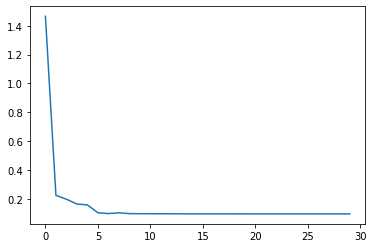

In [ ]:
word_dim = vocab_size
hidden_dim = 100
#X_train, y_train = getSentenceData('data/reddit-comments-2015-08.csv', word_dim)

np.random.seed(10)
np.random.seed(10)
rnn = Model(word_dim, hidden_dim)
import matplotlib.pyplot as plt

losses = rnn.train(x_train, y_train, learning_rate=0.005, nepoch=30, evaluate_loss_after=1)
plt.plot(losses)

Testing On Test Dataset

In [ ]:
output_seq = []
cnt = 0
for i in range(len(x_test)):
       
        pred = rnn.predict(x_test[i])
        predicted = [idx_to_word[id] for id in pred]
        print("Predicted :  ",predicted)
        print("Actual seq : ", y_test[i])
        print("Original seq:", x_test[i])
        print()
        if predicted == y_test[i]:
          cnt = cnt + 1
        actual = y_test
        output_seq.append(predicted) 

Predicted :   ['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Actual seq :  ['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Original seq: ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Predicted :   ['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'EOS']
Actual seq :  ['a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Original seq: ['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b']

Predicted :   ['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Actual seq :  ['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Original seq: ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Predicted :   ['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Actual seq :  ['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Original seq: ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', '

In [ ]:
#------Calculating WER--------------#
w_err = []
w_acc = []
for i in range(len(output_seq)):
  pred = output_seq[i]
  act = y_test[i]
  wer = 0
  wacc = 0
  for k in range(len(act)):
    if pred[k] != act[k]:
      wer = wer +1
    else:
      wacc = wacc +1
  w_err.append(wer/len(act))
  w_acc.append(wacc/len(act))


print("Total Word error Rate : ", sum(w_err)/len(w_err))
print("Total Word Accuracy : ", sum(w_acc)/len(w_acc))

Total Word error Rate :  0.06316666666666661
Total Word Accuracy :  0.9368333333333342


Training Data

In [ ]:
#-------------------Training Data-------------#
output_seq = []
cnt = 0
for i in range(len(x_train)):
       
        pred = rnn.predict(x_train[i])
        predicted = [idx_to_word[id] for id in pred]
        output_seq.append(predicted) 
        if predicted == y_train[i]:
          cnt = cnt + 1

In [ ]:
#------Calculating WER--------------#
w_err = []
w_acc = []
for i in range(len(output_seq)):
  pred = output_seq[i]
  act = y_train[i]
  wer = 0
  wacc = 0
  for k in range(len(act)):
    if pred[k] != act[k]:
      wer = wer +1
    else:
      wacc = wacc +1
  w_err.append(wer/len(act))
  w_acc.append(wacc/len(act))


print("Total Word error Rate : ", sum(w_err)/len(w_err))
print("Total Word Accuracy : ", sum(w_acc)/len(w_acc))

Total Word error Rate :  0.0592916666666667
Total Word Accuracy :  0.9407083333333328


## Inferences and conclusions

1. Test accuracy :
Total Word error Rate :  0.06316666666666661

Total Word Accuracy :  0.9368333333333342


2. Train accuracy : 

Total Word error Rate :  0.0592916666666667

Total Word Accuracy :  0.9407083333333328

3. There is a problem about RNN called vanishing gradient problem. That's why traditional RNN cannot capture the long term dependency, so we use bptt_truncate parameter to constrain the length of dependency
